RQ1 - What is the current state of Docker image development and how did it evolve over time?
==============

# Dependencies and Configurations

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
import psycopg2
import os
import re

## Database Configurations

In [2]:
POSTGRESQL_USER = os.getenv('POSTGRESQL_USER') if os.getenv('POSTGRESQL_USER') is not None else 'dockerstudy'
POSTGRESQL_PASSWORD = os.getenv('POSTGRESQL_PASSWORD') if os.getenv('POSTGRESQL_PASSWORD') is not None else 'dockerstudy'
POSTGRESQL_HOST_IP = os.getenv('POSTGRESQL_HOST_IP') if os.getenv('POSTGRESQL_HOST_IP') is not None else 'localhost'
POSTGRESQL_PORT = os.getenv('POSTGRESQL_PORT') if os.getenv('POSTGRESQL_PORT') is not None else '5432'
POSTGRESQL_DATABASE = os.getenv('POSTGRESQL_DATABASE') if os.getenv('POSTGRESQL_DATABASE') is not None else 'dockerstudy'

## Load the relevant tables

In [3]:
conn = psycopg2.connect(database=POSTGRESQL_DATABASE, user=POSTGRESQL_USER, password=POSTGRESQL_PASSWORD, host=POSTGRESQL_HOST_IP, port=POSTGRESQL_PORT)
Images = pd.read_sql_query('select * from public.image', con = conn)
Dockerfiles = pd.read_sql_query('select * from public.dockerfile', con = conn)
Repositories = pd.read_sql_query('select * from public.repository', con = conn)
Tags = pd.read_sql_query('select * from public.tag', con = conn)
conn.close()

# Results

## Programming Languages

In [5]:
def get_second_language(dic):
    try:
        line_count = list(dic.values())
        line_count.sort()
        second_language = [key for key in dic.keys() if dic[key]==line_count[-2]][0]
        return second_language
    except:
        return None

In [6]:
first_language = Repositories['language'].copy()
second_language = Repositories['languages'].apply(lambda dic: get_second_language(dic))
second_language = second_language.fillna(value=0)
first_language.update(pd.Series(second_language[first_language[first_language=='Dockerfile'].index].values, index=first_language[first_language=='Dockerfile'].index))
first_language = first_language[first_language!=0]
processed_language = Repositories.query("language!='Dockerfile'")['language'].copy()

In [7]:
first_language = first_language.dropna()
language_proportion=first_language.value_counts()/len(first_language)*100.0
print('Top 10 popular programming languages used in Docker images')
print(language_proportion[:10])

Top 10 popular programming languages used in Docker images
Shell         36.603899
Python        12.657915
JavaScript    11.910003
Go             8.832162
Java           4.861424
HTML           3.478319
Makefile       2.672059
PHP            2.461212
Ruby           2.405959
TypeScript     1.826460
Name: language, dtype: float64


In [8]:
# Over time
year_list=range(2015,2021)
all_language_trend=pd.DataFrame(columns=['Year','Language','Proportion'])
processed_language_updated_year = Repositories['updated_at'].apply(lambda x:x.year if x is not None else None)[processed_language.index]
for year in year_list:
    current_year_index=processed_language_updated_year[processed_language_updated_year==year].index
    current_year_language=processed_language[current_year_index].dropna()
    language_proportion=current_year_language.value_counts()/len(current_year_language)*100.0
    for i in range(language_proportion.size):
        all_language_trend=all_language_trend.append(pd.DataFrame([[year,language_proportion.index[i],language_proportion[i]]],columns=['Year','Language','Proportion']),ignore_index=True)


language_trend=pd.DataFrame(columns=['Year','Language','Proportion'])
for year in year_list:
    current_year_index=processed_language_updated_year[processed_language_updated_year==year].index
    current_year_language=processed_language[current_year_index].dropna()
    language_proportion=current_year_language.value_counts()/len(current_year_language)*100.0
    for i in range(10):
        try:
            language_trend=language_trend.append(pd.DataFrame([[year,language_proportion.index[i],language_proportion[i]]],columns=['Year','Language','Proportion']),ignore_index=True)
        except:
            continue
lang=language_trend['Language'].drop_duplicates()
lang.index=range(0,lang.size)
for year in year_list:
    for i in range(0,lang.size):
        dt=language_trend.query("Year=={} and Language=='{}'".format(year,lang[i]))
        if(dt.shape[0]==0):
            try:
                prop=all_language_trend.query("Year=={} and Language=='{}'".format(year,lang[i]))['Proportion']
                prop=prop[prop.index[0]]
            except:
                prop=0
            language_trend=language_trend.append(pd.DataFrame([[year,lang[i],prop]],columns=['Year','Language','Proportion']),ignore_index=True)

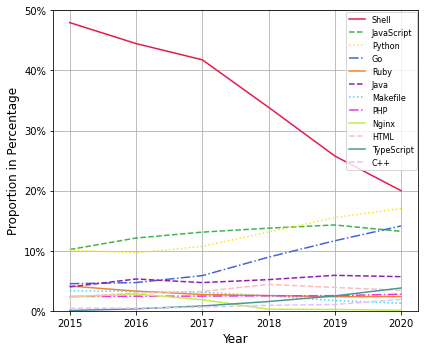

In [12]:
colors_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe', '#469990', '#e6beff', '#9A6324', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
linestyles = ['-', '--', '-.', ':']
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
fig=plt.figure(figsize=(6,5))
ax=plt.subplot(111)
ax.grid()
ax.set_ylim(0,50)
for i in range(0,lang.size):
    ax.plot(year_list, language_trend[language_trend['Language']==lang[i]].sort_values(by=['Year'])['Proportion'], label=lang[i], color=colors_list[i]) 
ax.legend(loc='upper right', bbox_to_anchor=(1.009,1.009),  prop={'size': 8})
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Proportion in Percentage', fontsize=12)
plt.tight_layout()
fig.savefig('popular-languages-over-time', dpi=300)
fig.savefig('popular-languages-over-time.pdf')

## Base Images

In [13]:
namematch_image_name = Images.query("source_repo_source=='NameMatch'")['image_name']

dockerfiles_desctime_order = Dockerfiles.copy().sort_values(by='committer_committed_at', ascending=False)
dockerfiles_desctime_order = dockerfiles_desctime_order.drop_duplicates(subset=['image_name'], keep='first')

dockerfiles_desctime_order_image_name = dockerfiles_desctime_order['image_name'].copy()

image_name_union = pd.merge(dockerfiles_desctime_order_image_name, namematch_image_name, how='inner')['image_name']

dockerfiles_namematch = dockerfiles_desctime_order[dockerfiles_desctime_order['image_name'].isin(image_name_union)]

dockerfiles_namematch = dockerfiles_namematch[['image_name', 'content', 'committer_committed_at']]

dockerfiles_namematch.columns = ['image_name', 'dockerfile', 'updated_at']

dockerfiles_ci = Images.query("latest_dockerfile!='' and source_repo_source=='CI'").copy()[['image_name', 'latest_dockerfile', 'updated_at']]

dockerfiles_ci.columns = ['image_name', 'dockerfile', 'updated_at']

dockeriles_ci_and_namematch = dockerfiles_ci.append(dockerfiles_namematch)
dockeriles_ci_and_namematch = dockeriles_ci_and_namematch.dropna()
dockeriles_ci_and_namematch.index = list(range(0, dockeriles_ci_and_namematch.shape[0]))

In [14]:
# Function for extracting Docker base images
def base_image_parser(dockerfile):
    dockerfile=dockerfile.replace('\t',' ')
    try:
        res=re.findall('(?<=FROM ).*?(?=\\n)', dockerfile, re.IGNORECASE)
        if(res==[]):
            res=re.findall('(?<=FROM ).*?(?=\\r)', dockerfile, re.IGNORECASE)
        if(res==[]):
            res=re.findall('(?<=FROM ).*?', dockerfile, re.IGNORECASE)
        base_image_full_name=res[0]
        name_split=base_image_full_name.split(':')
        base_image_name=name_split[0]
        characters=['\r','\n']
        if(len(name_split)==1):
            base_image_tag='latest'
        else:
            base_image_tag=name_split[1]
        for char in characters:
            base_image_full_name=base_image_full_name.replace(char,'')
            base_image_name=base_image_name.replace(char,'')
            base_image_tag=base_image_tag.replace(char,'')
        return (base_image_full_name,base_image_name,base_image_tag)
    except:
        return None

In [15]:
# Function to convert Ubuntu version
def ubuntu_version_converter(tup):
    version_dict = {'bionic':'18.04', 'trusty':'14.04', 'eoan':'19.10', 'xenial':'16.04', '14.04 ':'14.04', 'precise':'12.04', 'vivid':'15.04',
                    'utopic':'14.10', 'wily':'15.10', 'saucy':'13.10', 'zesty':'17.04', 'artful':'17.10', 'disco':'19.04', 'cosmic':'18.10',
                   'focal':'20.04', 'quantal':'12.10', 'latest ':'latest', 'yakkety':'16.10'}
    if tup[1]=='ubuntu':
        newtag = version_dict.get(tup[2]) if version_dict.get(tup[2]) is not None else tup[2]
        if 'as' in tup[2].lower():
            newtag = tup[2].lower().split(' as ')[0]
        return (tup[0], tup[1], newtag)
    return tup

In [16]:
parsed_base_images = dockeriles_ci_and_namematch['dockerfile'].apply(lambda x : base_image_parser(x))
dockeriles_ci_and_namematch['base_image'] = parsed_base_images
dockeriles_ci_and_namematch = dockeriles_ci_and_namematch.dropna()
dockeriles_ci_and_namematch.index = range(0, dockeriles_ci_and_namematch.shape[0])

In [17]:
dockeriles_ci_and_namematch['base_image'] = dockeriles_ci_and_namematch['base_image'].apply(lambda x : ubuntu_version_converter(x))

In [18]:
base_image_name = dockeriles_ci_and_namematch['base_image'].apply(lambda x : x[1])
base_image_tag = dockeriles_ci_and_namematch['base_image'].apply(lambda x : x[2])
dockeriles_ci_and_namematch['base_image_name'] = base_image_name
dockeriles_ci_and_namematch['base_image_tag'] = base_image_tag

In [19]:
base_image_name_proportion=base_image_name.value_counts()/len(base_image_name)*100.0
print('Top 10 most popular Docker base images')
print(base_image_name_proportion[:10])

Top 10 most popular Docker base images
ubuntu     13.477719
alpine      8.822649
node        8.499396
python      6.263726
debian      5.011124
golang      4.340375
centos      3.056636
php         2.851988
openjdk     2.291288
nginx       2.223548
Name: base_image, dtype: float64


In [20]:
# Over time
update_year = dockeriles_ci_and_namematch['updated_at'].apply(lambda x : x.year)
dockeriles_ci_and_namematch['update_year']=update_year
year_list=range(2015,2021)
all_base_image_name_trend=pd.DataFrame(columns=['Year','Image_Name','Proportion'])
for year in year_list:
    base=dockeriles_ci_and_namematch[dockeriles_ci_and_namematch['update_year']==year]
    base_proportion=base['base_image_name'].value_counts()/len(base)*100.0
    for i in range(base_proportion.size):
        all_base_image_name_trend=all_base_image_name_trend.append(pd.DataFrame([[year,base_proportion.index[i],base_proportion[i]]],columns=['Year','Image_Name','Proportion']),ignore_index=True)
# Over time
base_trend=pd.DataFrame(columns=['Year','Image_Name','Proportion'])
for year in year_list:
    base=dockeriles_ci_and_namematch[dockeriles_ci_and_namematch['update_year']==year]
    base_proportion=base['base_image_name'].value_counts()/len(base)*100.0
    for i in range(15):
        try:
            base_trend=base_trend.append(pd.DataFrame([[year,base_proportion.index[i],base_proportion[i]]],columns=['Year','Image_Name','Proportion']),ignore_index=True)
        except:
            continue
bs=base_trend['Image_Name'].drop_duplicates()
bs.index=range(0,bs.size)
for year in year_list:
    for i in range(0,bs.size):
        dt=base_trend.query("Year=={} and Image_Name=='{}'".format(year,bs[i]))
        if(dt.shape[0]==0):
            try:
                prop=all_base_image_name_trend.query("Year=={} and Image_Name=='{}'".format(year,bs[i]))['Proportion']
                prop=prop[prop.index[0]]
            except:
                prop=0
            base_trend=base_trend.append(pd.DataFrame([[year,bs[i],prop]],columns=['Year','Image_Name','Proportion']),ignore_index=True)

In [21]:
os_images = ['ubuntu', 'alpine', 'debian', 'centos', 'phusion/baseimage', 'fedora', 'gliderlabs/alpine']
lang_images = ['node', 'python', 'golang', 'php', 'openjdk', 'java', 'ruby', 'dockerfile/java', 'mhart/alpine-node', 'scratch', 'microsoft/dotnet', 'mcr.microsoft.com/dotnet/core/sdk', 'mcr.microsoft.com/dotnet/core/aspnet']
app_images = ['nginx', 'maven', 'jenkins/jenkins']
base_type_trend = pd.DataFrame(columns = ['Year', 'Image_Type', 'Proportion'])
for year in range(2015, 2021):
    OS = base_trend[base_trend['Image_Name'].isin(os_images)].query("Year=={}".format(year))['Proportion'].sum()
    Language = base_trend[base_trend['Image_Name'].isin(lang_images)].query("Year=={}".format(year))['Proportion'].sum()
    Application = base_trend[base_trend['Image_Name'].isin(app_images)].query("Year=={}".format(year))['Proportion'].sum()
    base_type_trend = base_type_trend.append(pd.DataFrame([[year, 'OS', OS], [year, 'Language', Language], [year, 'Application', Application]], columns = ['Year', 'Image_Type', 'Proportion']))

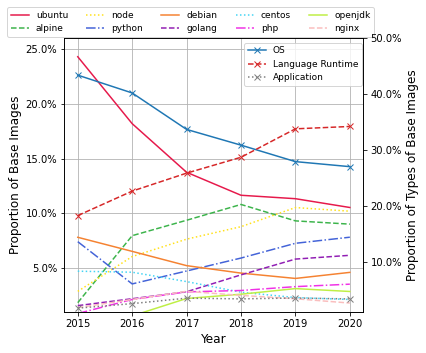

In [43]:
colors_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe', '#469990', '#e6beff', '#9A6324', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
linestyles = ['-', '--', '-.', ':']
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
fig=plt.figure(figsize=(6,5))
ax=plt.subplot(111)
ax2 = ax.twinx()
ax.grid()
ax.set_ylim(1,26)
ax2.set_ylim(1,50)
bs=pd.Series(base_image_name_proportion[:10].index)
for i in range(0,bs.size):
    ax.plot(year_list, base_trend[base_trend['Image_Name']==bs[i]].sort_values(by=['Year'])['Proportion'], label=bs[i],color=colors_list[i]) 
ax2.plot(year_list, base_type_trend[base_type_trend['Image_Type'] == 'OS'].sort_values(by=['Year'])['Proportion'], label='OS', marker='x', color='tab:blue')
ax2.plot(year_list, base_type_trend[base_type_trend['Image_Type'] == 'Language'].sort_values(by=['Year'])['Proportion'], label='Language Runtime', marker='x', color='tab:red')
ax2.plot(year_list, base_type_trend[base_type_trend['Image_Type'] == 'Application'].sort_values(by=['Year'])['Proportion'], label='Application', marker='x', color='tab:grey')

ax.legend(loc='upper right',  bbox_to_anchor=(1.05, 1.13), prop={'size': 9}, ncol=5)
ax2.legend(loc='upper right', bbox_to_anchor=(1.01, 1), prop={'size': 9})
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Proportion of Base Images', fontsize=12)
ax2.set_ylabel('Proportion of Types of Base Images', fontsize=12)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.tight_layout()
fig.savefig('popular-base-images-over-time', dpi=300)
fig.savefig('popular-base-images-over-time.pdf')

## OS Versions (Ubuntu)

In [29]:
ubuntu_images=dockeriles_ci_and_namematch.query("base_image_name=='ubuntu'")
ubuntu_image_tags=ubuntu_images['base_image_tag']
ubuntu_image_tags_proportion=ubuntu_image_tags.value_counts()/len(ubuntu_image_tags)*100.0
print('Top 15 most popular tags for ubuntu base images')
print(ubuntu_image_tags_proportion[:15])

Top 15 most popular tags for ubuntu base images
14.04      26.287387
16.04      25.751270
latest     18.859340
18.04      16.596713
12.04       2.354331
17.10       0.864137
15.10       0.783014
15.04       0.756560
19.04       0.589024
19.10       0.562571
18.10       0.557280
17.04       0.502610
20.04       0.497319
16.10       0.488502
14.04.3     0.442650
Name: base_image_tag, dtype: float64


In [30]:
# Over time
year_list=range(2015,2021)
all_ubuntu_tag_trend=pd.DataFrame(columns=['Year','Tag_Name','Proportion'])
for year in year_list:
    tag=dockeriles_ci_and_namematch.query("base_image_name=='ubuntu' and update_year=={}".format(year))
    tag_proportion=tag['base_image_tag'].value_counts()/len(tag)*100.0
    for i in range(tag_proportion.size):
        all_ubuntu_tag_trend=all_ubuntu_tag_trend.append(pd.DataFrame([[year,tag_proportion.index[i],tag_proportion[i]]],columns=['Year','Tag_Name','Proportion']),ignore_index=True)
# Over time
ubuntu_tag_trend=pd.DataFrame(columns=['Year','Tag_Name','Proportion'])
for year in year_list:
    tag=dockeriles_ci_and_namematch.query("base_image_name=='ubuntu' and update_year=={}".format(year))
    tag_proportion=tag['base_image_tag'].value_counts()/len(tag)*100.0
    for i in range(15):
        try:
            ubuntu_tag_trend=ubuntu_tag_trend.append(pd.DataFrame([[year,tag_proportion.index[i],tag_proportion[i]]],columns=['Year','Tag_Name','Proportion']),ignore_index=True)
        except:
            continue
utg=ubuntu_tag_trend['Tag_Name'].drop_duplicates()
utg.index=range(0,utg.size)
for year in year_list:
    for i in range(0,utg.size):
        dt=ubuntu_tag_trend.query("Year=={} and Tag_Name=='{}'".format(year,utg[i]))
        if(dt.shape[0]==0):
            try:
                prop=all_ubuntu_tag_trend.query("Year=={} and Tag_Name=='{}'".format(year,utg[i]))['Proportion']
                prop=prop[prop.index[0]]
            except:
                prop=0
            ubuntu_tag_trend=ubuntu_tag_trend.append(pd.DataFrame([[year,utg[i],prop]],columns=['Year','Tag_Name','Proportion']),ignore_index=True)

In [31]:
vulnerable_versions = {
    2015: ['10.04', '13.10', '14.10'],
    2016: ['10.04', '13.10', '14.10', '15.04', '15.10'],
    2017: ['10.04', '13.10', '14.10', '15.04', '15.10', '12.04', '16.10'],
    2018: ['10.04', '13.10', '14.10', '15.04', '15.10', '12.04', '16.10', '17.04', '17.10'],
    2019: ['10.04', '13.10', '14.10', '15.04', '15.10', '12.04', '16.10', '17.04', '17.10', '14.04', '18.10', '14.04.1', '14.04.2', '14.04.3', '14.04.4', '14.04.5'],
    2020: ['10.04', '13.10', '14.10', '15.04', '15.10', '12.04', '16.10', '17.04', '17.10', '14.04', '18.10', '14.04.1', '14.04.2', '14.04.3', '14.04.4', '14.04.5', '19.04', '19.10']
}
ubuntu_vernerable_tag_trend = []
for year in range(2015, 2021):
    ubuntu_vernerable_tag_trend.append(ubuntu_tag_trend[ubuntu_tag_trend['Tag_Name'].isin(vulnerable_versions[year])].query('Year=={}'.format(year))['Proportion'].sum())

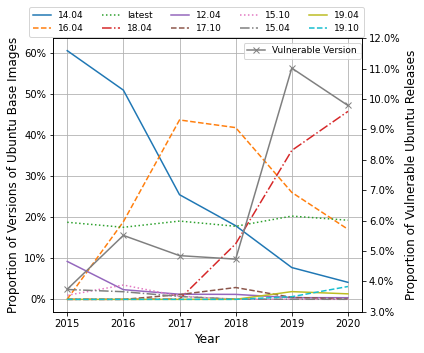

In [60]:
colors_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe', '#469990', '#e6beff', '#9A6324', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
linestyles = ['-', '--', '-.', ':']
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
fig=plt.figure(figsize=(6,5))
ax=plt.subplot(111)
ax2=ax.twinx()
ax.grid()
ax2.set_ylim(3,12)
utg=pd.Series(ubuntu_image_tags_proportion[:10].index)
for i in range(0,utg.size):
    ax.plot(year_list, ubuntu_tag_trend[ubuntu_tag_trend['Tag_Name']==utg[i]].sort_values(by=['Year'])['Proportion'], label=utg[i]) 
ax2.plot(year_list, ubuntu_vernerable_tag_trend, label='Vulnerable Version', marker='x', color='tab:grey')
ax.legend()
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Proportion of Versions of Ubuntu Base Images', fontsize=12)
ax2.set_ylabel('Proportion of Vulnerable Ubuntu Releases', fontsize=12)
ax.legend(loc='upper right',  bbox_to_anchor=(1.02, 1.13), prop={'size': 9}, ncol=5)
ax2.legend(loc='upper right', bbox_to_anchor=(1.01, 1), prop={'size': 9})
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.tight_layout()
fig.savefig('popular-ubuntu-tags-over-time', dpi=300)
fig.savefig('popular-ubuntu-tags-over-time.pdf')

## Image Architectures

In [33]:
image_architecture = Tags['architecture'].copy()
image_architecture = image_architecture.dropna()
image_architecture = image_architecture.apply(lambda x: 'amd64' if x=='x86_64' else x)

In [34]:
image_architecture_proportion=image_architecture.value_counts()/len(image_architecture)*100.0
print('Top 10 architectures of Docker images')
print(image_architecture_proportion[:10])

Top 10 architectures of Docker images
amd64       98.090237
arm64        0.753340
arm          0.727096
ppc64le      0.156646
386          0.119461
s390x        0.112116
             0.035466
mips64le     0.004292
ppc64        0.000362
config       0.000247
Name: architecture, dtype: float64


In [35]:
# Over time
year_list=range(2015,2021)
all_architecture_trend=pd.DataFrame(columns=['Year','Architecture','Proportion'])
processed_architecture_updated_year = Tags['last_updated'].apply(lambda x:x.year if x is not None else None)[image_architecture.index]
for year in year_list:
    current_year_index=processed_architecture_updated_year[processed_architecture_updated_year==year].index
    current_year_architecture=image_architecture[current_year_index].dropna()
    architecture_proportion=current_year_architecture.value_counts()/len(current_year_architecture)*100.0
    for i in range(architecture_proportion.size):
        all_architecture_trend=all_architecture_trend.append(pd.DataFrame([[year,architecture_proportion.index[i],architecture_proportion[i]]],columns=['Year','Architecture','Proportion']),ignore_index=True)


architecture_trend=pd.DataFrame(columns=['Year','Architecture','Proportion'])
for year in year_list:
    current_year_index=processed_architecture_updated_year[processed_architecture_updated_year==year].index
    current_year_architecture=image_architecture[current_year_index].dropna()
    architecture_proportion=current_year_architecture.value_counts()/len(current_year_architecture)*100.0
    for i in range(10):
        try:
            architecture_trend=architecture_trend.append(pd.DataFrame([[year,architecture_proportion.index[i],architecture_proportion[i]]],columns=['Year','Architecture','Proportion']),ignore_index=True)
        except:
            continue
archi=architecture_trend['Architecture'].drop_duplicates()
archi.index=range(0,archi.size)
for year in year_list:
    for i in range(0,archi.size):
        dt=architecture_trend.query("Year=={} and Architecture=='{}'".format(year,archi[i]))
        if(dt.shape[0]==0):
            try:
                prop=all_architecture_trend.query("Year=={} and Architecture=='{}'".format(year,archi[i]))['Proportion']
                prop=prop[prop.index[0]]
            except:
                prop=0
            architecture_trend=architecture_trend.append(pd.DataFrame([[year,archi[i],prop]],columns=['Year','Architecture','Proportion']),ignore_index=True)

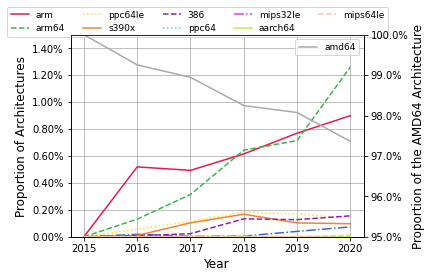

In [58]:
colors_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe', '#469990', '#e6beff', '#9A6324', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
linestyles = ['-', '--', '-.', ':']
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
fig=plt.figure(figsize=(6,4))
ax=plt.subplot(111)
ax.grid()
ax2 = ax.twinx()
ax2.set_ylim(95, 100)
archi_wo_amd64 = archi.drop(0)
archi_wo_amd64.index = list(range(0, archi_wo_amd64.size))
for i in range(0,10):
    ax.plot(year_list, architecture_trend[architecture_trend['Architecture']==archi_wo_amd64[i]].sort_values(by=['Year'])['Proportion'], label=archi_wo_amd64[i], color=colors_list[i]) 
amd64=['amd64']
for i in range(0,1):
    ax2.plot(year_list, architecture_trend[architecture_trend['Architecture']==amd64[i]].sort_values(by=['Year'])['Proportion'], label=amd64[i], color=colors_list[18]) 
ax.set_ylim(0,1.5)
#ax.legend(loc='upper left', bbox_to_anchor=(0,0.88),  prop={'size': 8})
ax.legend(loc='upper right',  bbox_to_anchor=(1.1, 1.16), prop={'size': 9}, ncol=5)
ax2.legend(loc='upper right', bbox_to_anchor=(1,1),  prop={'size': 9})
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Proportion of Architectures', fontsize=12)
ax2.set_ylabel('Proportion of the AMD64 Architecture', fontsize=12)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.tight_layout()
fig.savefig('architectures-over-time', dpi=300)
fig.savefig('architectures-over-time.pdf')

## Image Sizes

In [44]:
tags_info = Tags[['image_name', 'tag_name', 'last_updated', 'full_size']].copy()
tags_info['full_size'] = tags_info['full_size'].apply(lambda x : x/1024/1024 if(x is not None and x>0) else None)
tags_info['last_updated_year'] = tags_info['last_updated'].apply(lambda x : x.year if x is not None else None)
tags_info = tags_info.dropna()
tags_info = tags_info.reset_index(drop=True)

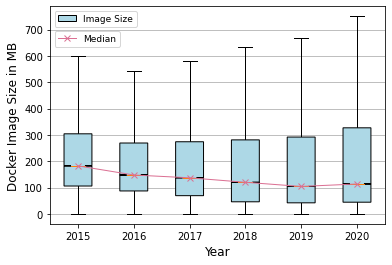

Median of the Docker Image Size in 2015: 182.42860984802246 MB
Median of the Docker Image Size in 2016: 147.81033062934875 MB
Median of the Docker Image Size in 2017: 137.15461215065488 MB
Median of the Docker Image Size in 2018: 120.11134147644043 MB
Median of the Docker Image Size in 2019: 104.34264755249023 MB
Median of the Docker Image Size in 2020: 113.75834798812866 MB


In [45]:
tag_size_in_year = [tags_info[tags_info['last_updated_year']==year].groupby(by='image_name').mean()['full_size'].values for year in list(range(2015, 2021))]
labels = list(range(2015, 2021))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
position_list = list(range(0, len(labels)))
bplot = ax.boxplot(tag_size_in_year,
                         notch=True,
                         vert=True,
                         patch_artist=True,
                         showfliers=False,
                         positions=position_list,
                         labels=labels, zorder=10)

avg_cost_line = ax.plot(position_list,  [np.median(tags_info[tags_info['last_updated_year']==year].groupby(by='image_name').mean()['full_size'].values) for year in range(2015, 2021)], linewidth=1, color='palevioletred', marker='x', markeredgecolor='palevioletred', zorder=20, label='Median')

for patch in bplot['boxes']:
    patch.set_facecolor('lightblue')
    
ax.yaxis.grid(True)
ax_legend1 = ax.legend(loc='center left', bbox_to_anchor=(0,0.85),  prop={'size': 9})
ax_legend = ax.legend([bplot["boxes"][0]], ['Image Size'], loc='upper left', bbox_to_anchor=(0,1),  prop={'size': 9})
ax.add_artist(ax_legend1)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Docker Image Size in MB', fontsize=12)
#ax.set_ylim(0, 800)
plt.show()
fig.tight_layout()
fig.savefig('Image_Size', dpi=300)
fig.savefig('Image_Size.pdf')
for year in range(2015, 2021):
    print('Median of the Docker Image Size in {}: {} MB'.format(year, np.median(tags_info[tags_info['last_updated_year']==year].groupby(by='image_name').mean()['full_size'].values)))

In [49]:
slope, intercept, r_value, p_value, std_err = stats.linregress(list(range(2015, 2021)), [np.median(tags_info[tags_info['last_updated_year']==year].groupby(by='image_name').mean()['full_size'].values) for year in range(2015, 2021)])
print('Slope:', slope)
print('R^2:', r_value*r_value)
print('p_value:', p_value)
print('std_err:', std_err)

Slope: -14.022789405835972
R^2: 0.854365719895893
p_value: 0.00837467233113481
std_err: 2.8947716822748806


In [50]:
tags_info = tags_info.sort_values('last_updated', ascending=False)
images_with_gte5_tags = tags_info[tags_info['image_name'].isin(tags_info['image_name'].value_counts()[tags_info['image_name'].value_counts()>=5].index)].copy()

def image_size_linregress(size_list):
    slope, intercept, r_value, p_value, std_err = stats.linregress(list(range(0, len(size_list))), size_list)
    return (slope, intercept, r_value*r_value, p_value, std_err)

image_with_gte5_tags_linreg = images_with_gte5_tags.groupby('image_name').apply(lambda x: image_size_linregress(x['full_size'].values))

image_with_gte5_tags_linreg_results = pd.DataFrame(columns=['slope', 'intercept', 'rsquare', 'p_value', 'std_err'])

image_with_gte5_tags_linreg_results['slope'] = image_with_gte5_tags_linreg.apply(lambda x : x[0])
image_with_gte5_tags_linreg_results['intercept'] = image_with_gte5_tags_linreg.apply(lambda x : x[1])
image_with_gte5_tags_linreg_results['rsquare'] = image_with_gte5_tags_linreg.apply(lambda x : x[2])
image_with_gte5_tags_linreg_results['p_value'] = image_with_gte5_tags_linreg.apply(lambda x : x[3])
image_with_gte5_tags_linreg_results['std_err'] = image_with_gte5_tags_linreg.apply(lambda x : x[4])

In [51]:
print('Percentage of Docker images with a statistically significant decreasing trend in size (p-value <= 0.05):', image_with_gte5_tags_linreg_results.query("slope<0 and p_value<=0.05").shape[0] / image_with_gte5_tags_linreg_results.shape[0] *100)
print('Percentage of Docker images with a statistically significant increasing trend in size (p-value <= 0.05):', image_with_gte5_tags_linreg_results.query("slope>0 and p_value<=0.05").shape[0] / image_with_gte5_tags_linreg_results.shape[0] *100)
print('Percentage of Docker images with a decreasing trend in size:', image_with_gte5_tags_linreg_results.query("slope<0").shape[0] / image_with_gte5_tags_linreg_results.shape[0] *100)
print('Percentage of Docker images with a increasing trend in size:', image_with_gte5_tags_linreg_results.query("slope>0").shape[0] / image_with_gte5_tags_linreg_results.shape[0] *100)

Percentage of Docker images with a statistically significant decreasing trend in size (p-value <= 0.05): 39.631259862137696
Percentage of Docker images with a statistically significant increasing trend in size (p-value <= 0.05): 12.24150818038369
Percentage of Docker images with a decreasing trend in size: 67.609833070343
Percentage of Docker images with a increasing trend in size: 31.07424632505606
